# Week 06 — Uncertainty & Statistics

This notebook focuses on quantifying uncertainty in predictions. You'll:
- Distinguish aleatoric vs epistemic uncertainty
- Implement Monte Carlo sampling and bootstrap
- Build Bayesian linear regression models
- Create calibration and reliability diagrams

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
%matplotlib inline

np.random.seed(42)
sns.set_style('whitegrid')
print("Libraries imported!")

Libraries imported!


In [ ]:

import os, pickle

CACHE_DIR = "cache_week08"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week06


## 1. Monte Carlo Basics

Estimate expectations and construct empirical confidence intervals using Monte Carlo sampling.

Monte Carlo Estimate:
  E[f(X)] ≈ 1.0053
  Std[f(X)] ≈ 1.5766
  95% CI: [-0.2310, 5.2724]


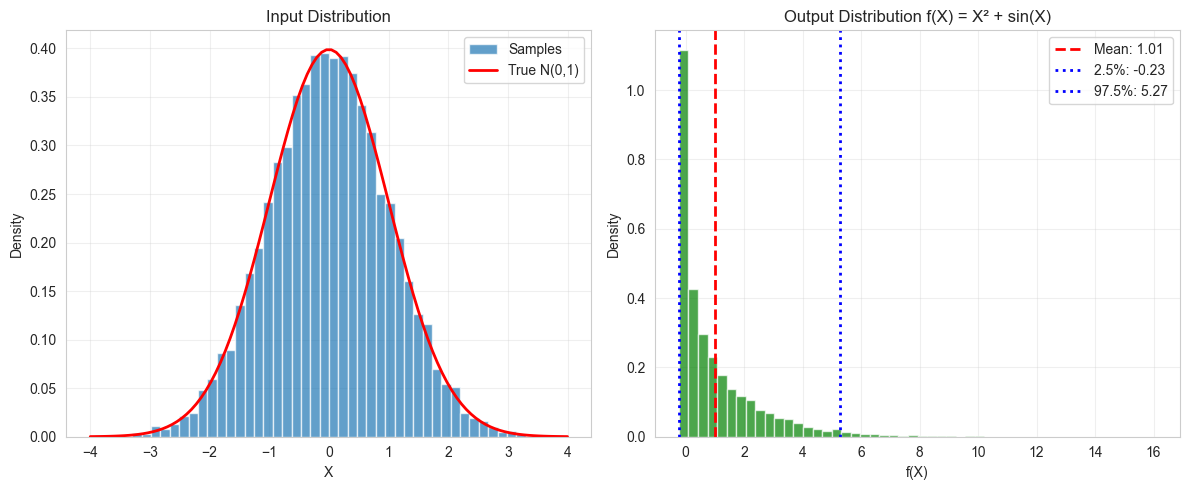

In [4]:
# Task: Estimate E[f(X)] where X ~ N(0, 1) and f(x) = x^2 + sin(x)

def f(x):
    """Target function"""
    return x**2 + np.sin(x)

# Monte Carlo estimation
n_samples = 10000
samples = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
f_samples = f(samples)

# Compute statistics
mc_mean = f_samples.mean()
mc_std = f_samples.std()
lower, upper = np.percentile(f_samples, [2.5, 97.5])

print(f"Monte Carlo Estimate:")
print(f"  E[f(X)] ≈ {mc_mean:.4f}")
print(f"  Std[f(X)] ≈ {mc_std:.4f}")
print(f"  95% CI: [{lower:.4f}, {upper:.4f}]")

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, alpha=0.7, density=True, label='Samples')
x_range = np.linspace(-4, 4, 100)
plt.plot(x_range, stats.norm.pdf(x_range), 'r-', linewidth=2, label='True N(0,1)')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Input Distribution')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(f_samples, bins=50, alpha=0.7, color='green', density=True)
plt.axvline(mc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mc_mean:.2f}')
plt.axvline(lower, color='blue', linestyle=':', linewidth=2, label=f'2.5%: {lower:.2f}')
plt.axvline(upper, color='blue', linestyle=':', linewidth=2, label=f'97.5%: {upper:.2f}')
plt.xlabel('f(X)')
plt.ylabel('Density')
plt.title('Output Distribution f(X) = X² + sin(X)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Bootstrap for Confidence Intervals

Implement nonparametric bootstrap to estimate uncertainty in statistics.

[cache] computing 'bootstrap_mean_median_2000'...
Mean:   estimate=4.230, 95% CI=[3.057, 5.517]
Median: estimate=2.864, 95% CI=[1.724, 4.088]


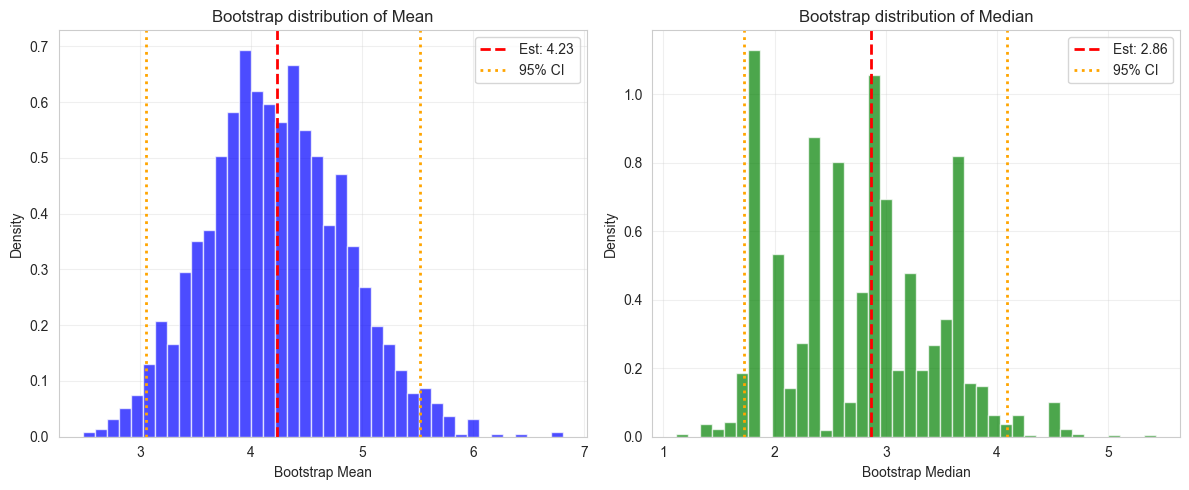

In [5]:

def bootstrap_stat(data, stat_fn, n_boot=1000, alpha=0.05):
    n = len(data)
    boot_stats = [stat_fn(np.random.choice(data, size=n, replace=True)) for _ in range(n_boot)]
    boot_stats = np.array(boot_stats)
    ci = np.percentile(boot_stats, [100*alpha/2, 100*(1-alpha/2)])
    return stat_fn(data), ci, boot_stats

true_mean = 5.0
np.random.seed(42)
data = np.random.exponential(scale=true_mean, size=50)

def _run_bootstrap():
    mean_est, mean_ci, mean_boots     = bootstrap_stat(data, np.mean,   n_boot=2000)
    median_est, median_ci, med_boots  = bootstrap_stat(data, np.median, n_boot=2000)
    return mean_est, mean_ci, mean_boots, median_est, median_ci, med_boots

(mean_est, mean_ci, mean_boots,
 median_est, median_ci, median_boots) = cached("bootstrap_mean_median_2000", _run_bootstrap)

print(f"Mean:   estimate={mean_est:.3f}, 95% CI=[{mean_ci[0]:.3f}, {mean_ci[1]:.3f}]")
print(f"Median: estimate={median_est:.3f}, 95% CI=[{median_ci[0]:.3f}, {median_ci[1]:.3f}]")

plt.figure(figsize=(12, 5))
for i, (boots, est, ci, label, color) in enumerate([
        (mean_boots,   mean_est,   mean_ci,   'Mean',   'blue'),
        (median_boots, median_est, median_ci, 'Median', 'green')]):
    plt.subplot(1, 2, i+1)
    plt.hist(boots, bins=40, alpha=0.7, color=color, density=True)
    plt.axvline(est,   color='red',    linestyle='--', linewidth=2, label=f'Est: {est:.2f}')
    plt.axvline(ci[0], color='orange', linestyle=':',  linewidth=2)
    plt.axvline(ci[1], color='orange', linestyle=':',  linewidth=2, label='95% CI')
    plt.xlabel(f'Bootstrap {label}'); plt.ylabel('Density')
    plt.title(f'Bootstrap distribution of {label}'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


## 3. Bayesian Linear Regression (Simple Implementation)

Implement Bayesian linear regression to obtain posterior distributions over parameters and predictions.

[cache] computing 'bayesian_linear_regression_n20'...


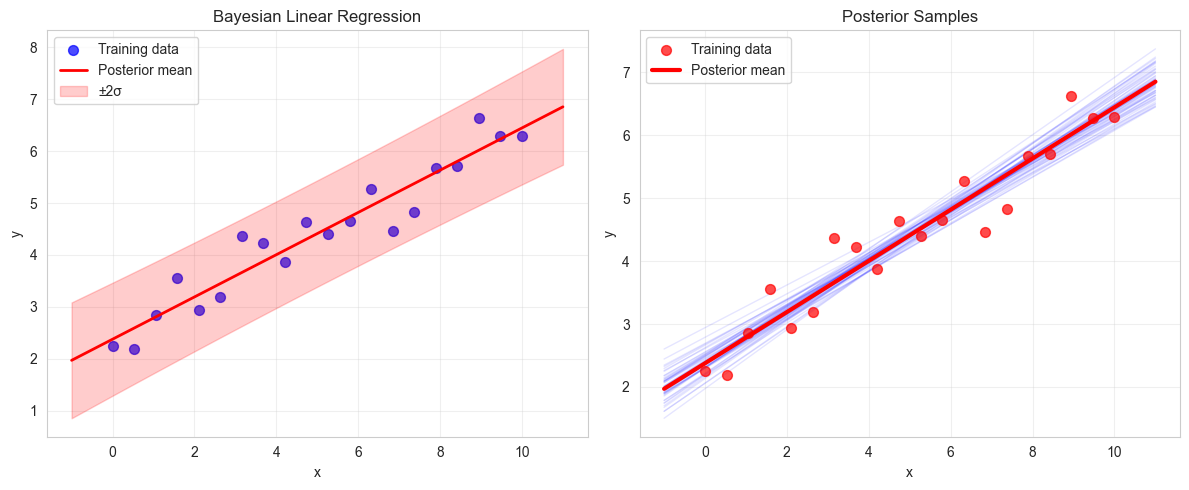

Posterior mean: [2.37652561 0.40697089]


In [6]:

class BayesianLinearRegression:
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha; self.beta = beta
        self.mu_post = None; self.Sigma_post = None

    def fit(self, X, y):
        n, d = X.shape
        self.Sigma_post = np.linalg.inv(self.alpha * np.eye(d) + self.beta * X.T @ X)
        self.mu_post = self.beta * self.Sigma_post @ X.T @ y
        return self

    def predict(self, X, return_std=True):
        mu_pred = X @ self.mu_post
        if return_std:
            var_pred = 1.0/self.beta + np.sum(X @ self.Sigma_post * X, axis=1)
            return mu_pred, np.sqrt(var_pred)
        return mu_pred

np.random.seed(42)
n_train = 20
X_train_blr = np.linspace(0, 10, n_train).reshape(-1, 1)
X_train_blr_bias = np.hstack([np.ones((n_train, 1)), X_train_blr])
y_train_blr = 2 + 0.5 * X_train_blr.ravel() + np.random.randn(n_train) * 0.5

def _fit_blr():
    blr = BayesianLinearRegression(alpha=0.1, beta=4.0)
    blr.fit(X_train_blr_bias, y_train_blr)
    return blr

blr = cached("bayesian_linear_regression_n20", _fit_blr)

X_test_blr = np.linspace(-1, 11, 100).reshape(-1, 1)
X_test_blr_bias = np.hstack([np.ones((100, 1)), X_test_blr])
mu_pred, std_pred = blr.predict(X_test_blr_bias, return_std=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train_blr, y_train_blr, color='blue', s=50, alpha=0.7, label='Training data')
plt.plot(X_test_blr, mu_pred, 'r-', linewidth=2, label='Posterior mean')
plt.fill_between(X_test_blr.ravel(), mu_pred - 2*std_pred, mu_pred + 2*std_pred,
                 alpha=0.2, color='red', label='±2σ')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Bayesian Linear Regression')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for _ in range(50):
    w_sample = np.random.multivariate_normal(blr.mu_post, blr.Sigma_post)
    plt.plot(X_test_blr, X_test_blr_bias @ w_sample, 'b-', alpha=0.1, linewidth=1)
plt.scatter(X_train_blr, y_train_blr, color='red', s=50, alpha=0.7, label='Training data', zorder=5)
plt.plot(X_test_blr, mu_pred, 'r-', linewidth=3, label='Posterior mean', zorder=10)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Posterior Samples')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()
print(f"Posterior mean: {blr.mu_post}")


## 4. Calibration and Reliability Diagrams

Assess whether predicted uncertainties are well-calibrated.

Calibration Check:
  Mean of z-scores: 0.058 (should be ~0)
  Std of z-scores: 1.020 (should be ~1)

Empirical Coverage:
  50% interval: 47.5% coverage (expected 50%)
  68% interval: 66.5% coverage (expected 68%)
  95% interval: 95.0% coverage (expected 95%)
  99% interval: 98.0% coverage (expected 99%)


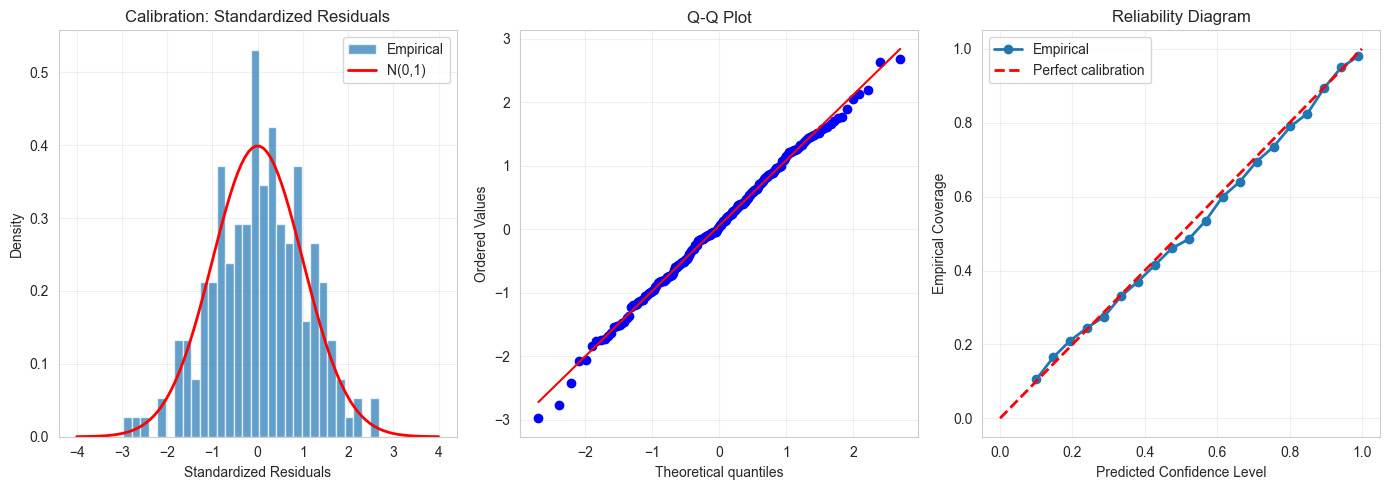

In [7]:
# Generate test data to evaluate calibration
np.random.seed(123)
n_test = 200
X_test_calib = np.random.uniform(0, 10, n_test).reshape(-1, 1)
X_test_calib_bias = np.hstack([np.ones((n_test, 1)), X_test_calib])
y_test_true = 2 + 0.5 * X_test_calib.ravel() + np.random.randn(n_test) * 0.5

# Predict
mu_test, std_test = blr.predict(X_test_calib_bias, return_std=True)

# Compute standardized residuals
z_scores = (y_test_true - mu_test) / std_test

# Check calibration: z_scores should be ~ N(0, 1)
print("Calibration Check:")
print(f"  Mean of z-scores: {z_scores.mean():.3f} (should be ~0)")
print(f"  Std of z-scores: {z_scores.std():.3f} (should be ~1)")

# Empirical coverage
coverage_levels = [0.5, 0.68, 0.95, 0.99]
print("\nEmpirical Coverage:")
for level in coverage_levels:
    z_crit = stats.norm.ppf((1 + level) / 2)
    in_interval = np.abs(z_scores) <= z_crit
    empirical_coverage = in_interval.mean()
    print(f"  {level*100:.0f}% interval: {empirical_coverage*100:.1f}% coverage (expected {level*100:.0f}%)")

# Reliability diagram
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(z_scores, bins=30, density=True, alpha=0.7, label='Empirical')
x_range = np.linspace(-4, 4, 100)
plt.plot(x_range, stats.norm.pdf(x_range), 'r-', linewidth=2, label='N(0,1)')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.title('Calibration: Standardized Residuals')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
stats.probplot(z_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Coverage plot
confidence_levels = np.linspace(0.1, 0.99, 20)
empirical_coverages = []
for level in confidence_levels:
    z_crit = stats.norm.ppf((1 + level) / 2)
    in_interval = np.abs(z_scores) <= z_crit
    empirical_coverages.append(in_interval.mean())

plt.plot(confidence_levels, empirical_coverages, 'o-', linewidth=2, label='Empirical')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
plt.xlabel('Predicted Confidence Level')
plt.ylabel('Empirical Coverage')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Exercises for Further Practice

1. **Heteroscedastic Modeling**: Build a model that predicts both mean and variance
2. **PyMC3 Bayesian Regression**: Implement full Bayesian regression using PyMC3 or NumPyro
3. **Conformal Prediction**: Implement distribution-free prediction intervals
4. **Ensemble Uncertainty**: Train multiple models and compare ensemble uncertainty to single-model uncertainty
5. **Real Dataset**: Apply uncertainty quantification to a real regression problem

## Deliverables Checklist

- [ ] Monte Carlo estimation with confidence intervals
- [ ] Bootstrap implementation and comparison to analytic intervals
- [ ] Bayesian linear regression with posterior predictive checks
- [ ] Calibration assessment with reliability diagrams
- [ ] Mini-project: uncertainty quantification on real or synthetic data

## Recommended Resources

- Murphy, "Machine Learning: A Probabilistic Perspective" (Bayesian inference chapter)
- "Bayesian Methods for Hackers" (practical PyMC examples)
- Scikit-learn docs on calibration and model evaluation
- Gelman et al., "Bayesian Data Analysis"

In [8]:

# EXERCISE 1 — Online Bayesian Updating
# Goal: start with the BLR prior. Feed data points one at a time (n=1 to 20).
# Plot the posterior predictive interval at each step, showing how it shrinks.
# Use cached("blr_sequential_updates_n20", ...) to save the list of (mu, Sigma) pairs.
# Expected insight: uncertainty decreases as more data arrives (fundamental Bayesian idea).


In [9]:

# EXERCISE 2 — Ensemble Uncertainty
# Goal: train 10 linear regression models, each on a different bootstrap subsample.
# At each test point, compute the mean and std of predictions across models.
# Plot error bars and compare to BLR's posterior predictive interval.
# Use cached("ensemble_uncertainty_10models", ...) to save the ensemble coefficients.
# Expected insight: ensemble spread ≈ epistemic uncertainty; wider in out-of-distribution regions.


In [10]:

# EXERCISE 4 — Calibration on Real Data
# Goal: pick sklearn's diabetes dataset (regression) or any classification dataset.
# Fit a Ridge model and build 95% prediction intervals using the BLR approach above.
# Compute the empirical coverage and plot a reliability diagram.
# Deliverable: one paragraph on whether the model is well-calibrated and why.
